# Assignment

In [1]:
from google.colab import drive
drive.mount('/content/drive')
content_path = "/content/drive/MyDrive/Colab Notebooks/dataset/content_nthu.jpg"
style_path = "/content/drive/MyDrive/Colab Notebooks/dataset/style_starry_night.jpg"

Mounted at /content/drive


In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Part I (A Neural Algorithm of Artistic Style)

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]
    
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

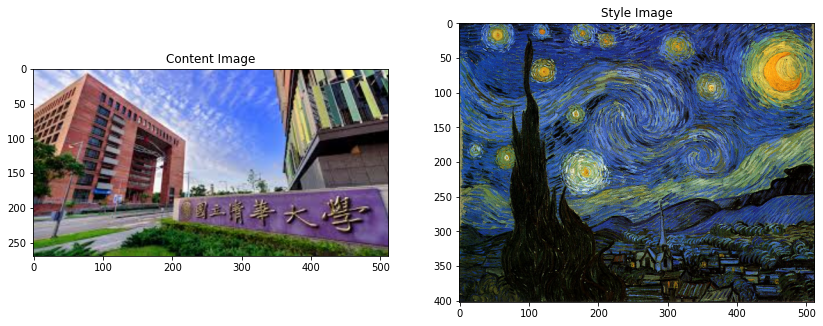

In [ ]:
content_path = './dataset/content_nthu.jpg'
style_path = './dataset/style_starry_night.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 402, 512, 64)
  min:  0.0
  max:  742.4454
  mean:  22.595304

block2_conv1
  shape:  (1, 201, 256, 128)
  min:  0.0
  max:  3492.055
  mean:  139.87125

block3_conv1
  shape:  (1, 100, 128, 256)
  min:  0.0
  max:  6940.378
  mean:  147.91318

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  15697.7
  mean:  543.7416

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  4195.862
  mean:  47.641136



## Calculate style

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

## Extract style and content

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.023810934
    max:  18674.498
    mean:  743.52576

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  111471.75
    mean:  20621.188

   block3_conv1
    shape:  (1, 256, 256)
    min:  1.0352992
    max:  739126.1
    mean:  21373.393

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5888397.0
    mean:  287949.28

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  114889.21
    mean:  2506.202

Contents:
   block5_conv2
    shape:  (1, 16, 32, 512)
    min:  0.0
    max:  942.2925
    mean:  18.336668


## Define loss

In [71]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss   

In [72]:
def shift_image(image, di=0, dj=0):
    img = tf.image.crop_to_bounding_box(image, di, dj, image.shape[1] - di, image.shape[2] - dj)
    img = tf.image.pad_to_bounding_box(img, 0, 0, image.shape[1], image.shape[2])
    return img

def total_variation_loss(image, up, lf):
    # up = shift_image(image, di=1)
    # lf = shift_image(image, dj=1)
    extra_term_col = tf.slice(image[0], [0, image.shape[2]-1, 0], [image.shape[1], 1, 3])
    extra_term_row = tf.slice(image[0], [image.shape[1]-1, 0, 0], [1, image.shape[2], 3])
    loss = (tf.reduce_sum(tf.abs(up-image)) + tf.reduce_sum(tf.abs(lf-image))
            - tf.reduce_sum(extra_term_col) - tf.reduce_sum(extra_term_row))
    return loss

# Verify the correctness of total variation loss
image = tf.Variable(content_image)
print(total_variation_loss(image, shift_image(image, di=1), shift_image(image, dj=1)))
print(tf.image.total_variation(image))

tf.Tensor(27254.271, shape=(), dtype=float32)
tf.Tensor([27254.271], shape=(1,), dtype=float32)


## Gradient descent

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [95]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:        
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
        up = shift_image(image, di=1)
        lf = shift_image(image, dj=1)
        loss += total_variation_weight*total_variation_loss(image, up, lf)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

## Weight tuning

In [ ]:
image = tf.Variable(content_image)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight_list = [0.01, 0.1, 1, 10, 100]
content_weight_list = [1]
total_variation_weight_list = [0.001, 0.1, 1, 10, 1000]

Style: 0.01, Content: 1, Total variation: 0.001


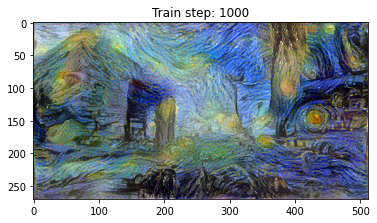

Style: 0.01, Content: 1, Total variation: 0.1


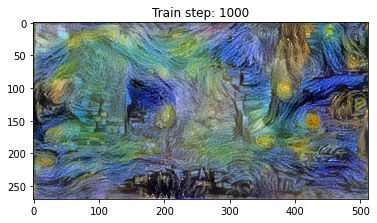

Style: 0.01, Content: 1, Total variation: 1


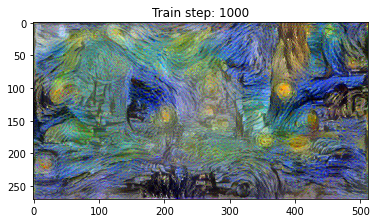

Style: 0.01, Content: 1, Total variation: 10


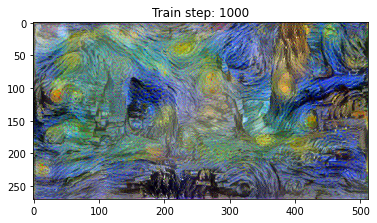

Style: 0.01, Content: 1, Total variation: 1000


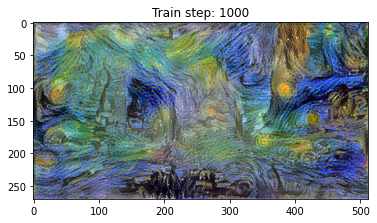

Style: 0.1, Content: 1, Total variation: 0.001


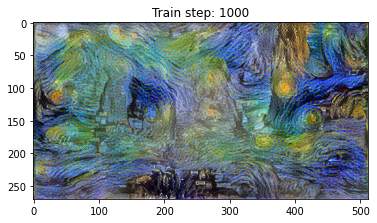

Style: 0.1, Content: 1, Total variation: 0.1


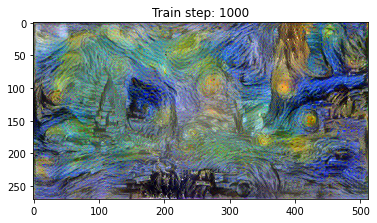

Style: 0.1, Content: 1, Total variation: 1


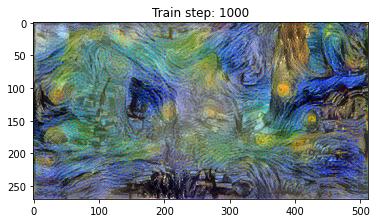

Style: 0.1, Content: 1, Total variation: 10


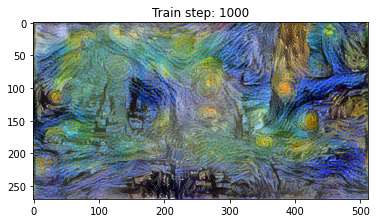

Style: 0.1, Content: 1, Total variation: 1000


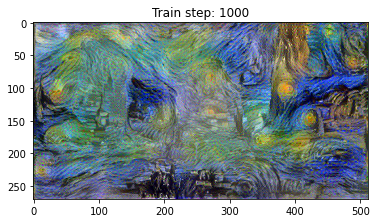

Style: 1, Content: 1, Total variation: 0.001


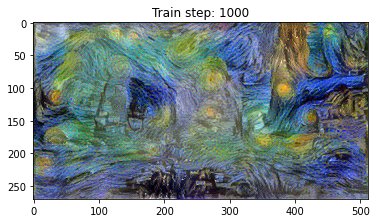

Style: 1, Content: 1, Total variation: 0.1


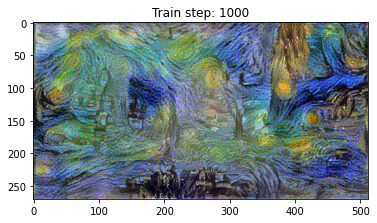

Style: 1, Content: 1, Total variation: 1


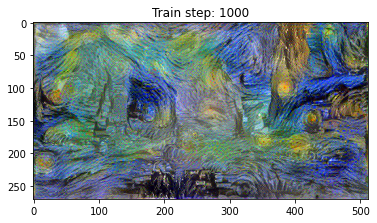

Style: 1, Content: 1, Total variation: 10


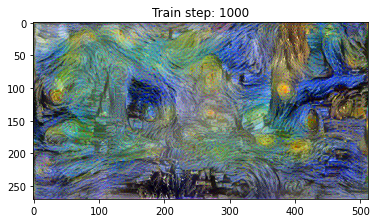

Style: 1, Content: 1, Total variation: 1000


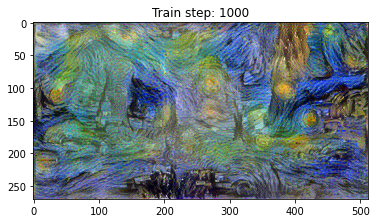

Style: 10, Content: 1, Total variation: 0.001


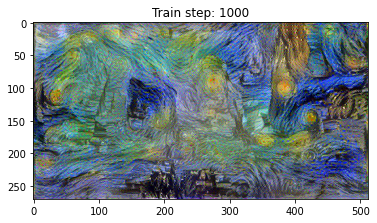

Style: 10, Content: 1, Total variation: 0.1


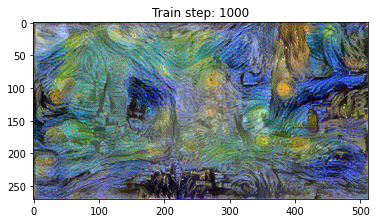

Style: 10, Content: 1, Total variation: 1


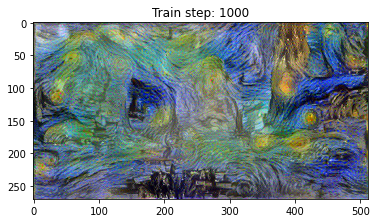

Style: 10, Content: 1, Total variation: 10


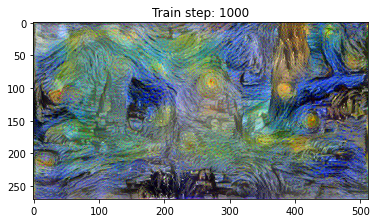

Style: 10, Content: 1, Total variation: 1000


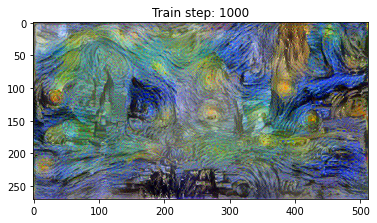

Style: 100, Content: 1, Total variation: 0.001


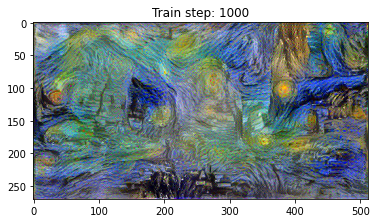

Style: 100, Content: 1, Total variation: 0.1


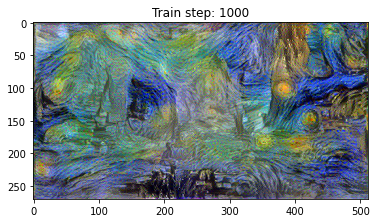

Style: 100, Content: 1, Total variation: 1


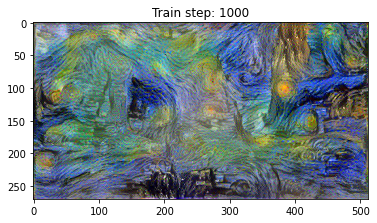

Style: 100, Content: 1, Total variation: 10


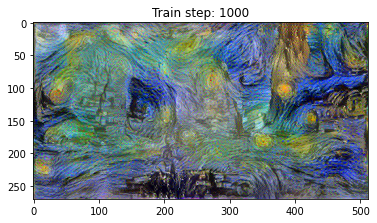

Style: 100, Content: 1, Total variation: 1000


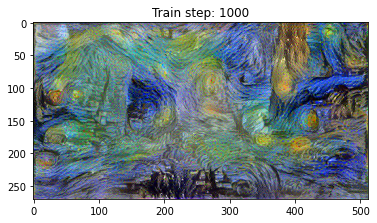

Total time: 4831.2


In [ ]:
start = time.time()

epochs = 10
steps_per_epoch = 100

for s in style_weight_list:
  for c in content_weight_list:
    for v in total_variation_weight_list:
      print(f'Style: {s}, Content: {c}, Total variation: {v}')
      
      image = tf.Variable(content_image)
      style_weight, content_weight, total_variation_weight = s, c, v
      step = 0
      
      for n in range(epochs):
          for m in range(steps_per_epoch):
              step += 1
              train_step(image)
      imshow(image.read_value()[0])
      plt.title("Train step: {}".format(step))
      plt.show()
      
      # file_name = f'./output/style_transfer_nthu_starry_night_s{s*100}_c{c}_v{v*10}.png'
      file_name = f'/content/drive/MyDrive/Colab Notebooks/output/style_transfer_nthu_starry_night_s{s*100}_c{c}_v{v*10}.png'
      mpl.image.imsave(file_name, image[0].numpy())

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Try other layers

In [22]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [96]:
# Content layer where will pull our feature maps
content_layers = ['block1_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = StyleContentModel(style_layers, content_layers)

In [97]:
image = tf.Variable(content_image)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 1
content_weight = 1
total_variation_weight = 1

In [75]:
def output_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    print(f'Style loss:\t{style_loss:.4f}\nContent loss:\t{content_loss:.4f}')
    return style_loss, content_loss

# style_loss = []    
# content_loss = []

Style loss:	11669535.0000
Content loss:	33941.1250


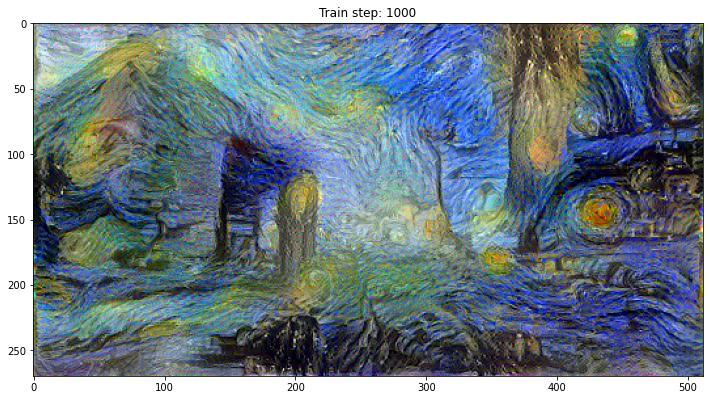

Total time: 0.5


In [100]:
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  #print(n)
  for m in range(steps_per_epoch):
      step += 1
      train_step(image)

# Output loss
outputs = extractor(image)
s, c = output_loss(outputs)
style_loss.append(s.numpy())
content_loss.append(c.numpy())

imshow(image.read_value()[0])
plt.title("Train step: {}".format(step))
plt.show()

# file_name = f'./output/style_transfer_nthu_starry_night_content1.png'
# file_name = f'/content/drive/MyDrive/Colab Notebooks/output/style_transfer_nthu_starry_night_content1.png'
# mpl.image.imsave(file_name, image[0].numpy())

end = time.time()
print("Total time: {:.1f}".format(end-start))

### Loss of different content layers

In [22]:
style_loss = np.array([11669535.0, 11676170.0, 11597583.0, 11654135.0, 11652564.0])
content_loss = np.array([33941.125, 118787.4, 113734.53, 768718.75, 5263.524])

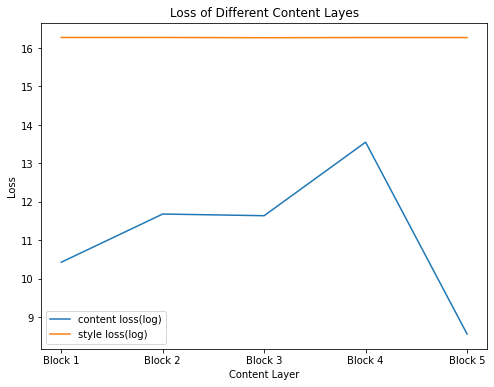

In [32]:
x = range(1, 6)
values = ['Block 1', 'Block 2', 'Block 3', 'Block 4', 'Block 5']
plt.figure(figsize=(8, 6))
plt.title('Loss of Different Content Layes')
plt.plot(x, np.log(content_loss), label='content loss(log)')
plt.plot(x, np.log(style_loss), label='style loss(log)')
plt.legend(loc='best')
plt.xticks(x, values)
plt.xlabel('Content Layer')
plt.ylabel('Loss')
plt.show()

## Part I Report


In [ ]:
###########
# To-Do:
# - report

# Part II AdaIN

In [ ]:
# file_name = './output/style_transfer_nthu_starry_night.png'
file_name = f'/content/drive/MyDrive/Colab Notebooks/output/style_transfer_nthu_starry_night_s{s*100}_c{c}_v{v*10}.png'
mpl.image.imsave(file_name, image[0].numpy())